# Statistical non-Parametric Mapping (SnPM) t test

This notebook describes a non-parametric t-test using **spm1d**. For additional details refer to the documentation at [spm1d.org](http://www.spm1d.org)

____________
## Step 1:  Load the data & rename variables

Following the previous notebook (SPM t test), let's load the data and rename the variables.

In [1]:
load('Warmenhoven2018-bow-force.mat');

yA = Pin_Force_Bow_Male';   %(10 x 51) array
yB = Pin_Force_Bow_Female'; %(10 x 51) array

____________
## Step 2:  Conduct t test

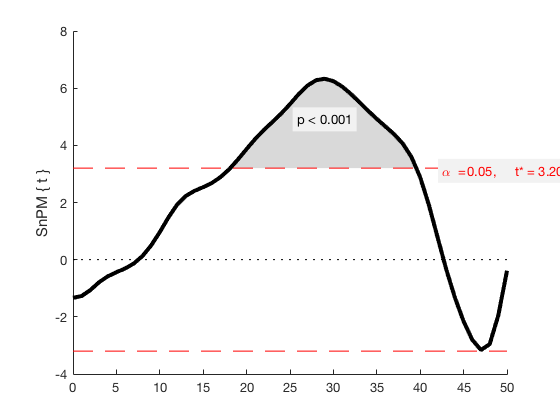

In [2]:
snpm  = spm1d.stats.nonparam.ttest2(yA, yB);
snpmi = snpm.inference(0.05, 'iterations', 10000, 'two_tailed', true);

snpmi.plot();
snpmi.plot_threshold_label(); 
snpmi.plot_p_values();

These results are qualitatively identical to the parametric results in the previous notebook.  The code is nearly the same too, with two exceptions:

* The **ttest2** function used for non-parametric testing is found in the "nonparam" folder: ./+spm1d/+stats/+nonparam/ttest2.m

* A value for "iterations" is needed for non-parametric inference.

To explain the meaning of "iterations" let's first consider the the attributes of the **snpm** variable:

In [3]:
disp(snpm)


SnPM{t} (1D)
              z: [1×51 double]
    nPermUnique: 184756



Like before the **z** attribute contains the test statistic continuum. There is a new attribute:

* **nPermUnique**: the number of unique permutations possible for (non-parametric) permutation testing. Continuum-level permutation testing is described in [Nichols & Holmes (2003)](https://doi.org/10.1002/hbm.1058) for 3D data and in [Pataky et al. 2015](https://doi.org/10.1016/j.jbiomech.2015.02.051) for 1D data. Basically, each observation is assigned a group label ("A" or "B"), then the labels are randomly permuted and the test statistic continuum is re-calculated and its maximum value is saved. This random permutation process is repeated *N* times, yielding a distribution of *N* maximum t values, and the critical test statistic value can be computed directly from this distribution.  Note that the distribution of maximum t values produced by this non-parametric permutation procedure will converge to the parametric distribution (from Random Field Theory) when the data are normally distributed.

The "iterations" argument in the **inference** method is *N*, or the number of random permutations to test.  Setting "iterations" to -1 will run through all of the unique permutations, but usually *N*=10,000 is sufficient to achieve numerical stability.

The output from **inference** contains some additional attributes:

In [4]:
disp(snpmi)


SnPM{t} inference (1D)
              z: [1×51 double]
    nPermUnique: 184756
    nPermActual: 10000
          alpha: 0.0500
          zstar: 3.2015
       h0reject: 1
              p: 1.0000e-04



Identical to parametric inference, the Type I error rate **alpha**, the critical threshold **zstar**, the null hyothesis rejection decision **h0reject**, and cluster-specific probablity values **p** are also attributes of non-parametric inference. The only new attribute is:

* **nPermActual**:  the actual number of permutations performed. Its maximum possible value is **nPermUnique**.

There are a number of additional attributes that are not displayed when calling the **disp** function. These can be viewed by double-clicking on the **snpmi** variable in **MATLAB**'s Workspace browser:

<img src="figs/screenshot-3-1.jpeg" width="300">

* **PDF0**: the primary probabilty density containing one maximum t value for each permutation
* **PDF1**: the secondary probabilty density containing one suprathreshold maximum cluster size value for each permutation
* **clusters**: a cell array of cluster objects, where each cluster object contains information like centroid, extent, probability value, etc.
* **nClusters**: the number of suprathreshold clusters
* **nNodes**: the number of continuum nodes (same as Q)
* **permuter**:  a permuter object that is used to control the permutations

The most important attribute here is **PDF0**; this is the probability density upon which the null hypothesis rejection decision is based.  Let's visualize it:

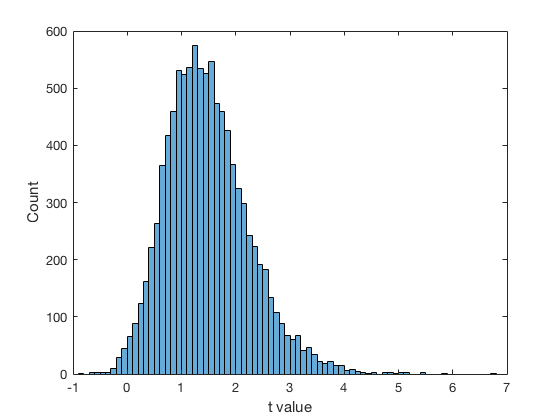

In [5]:
histogram( snpmi.PDF0 )
xlabel('t value')
ylabel('Count')

The 100(1 - alpha/2)th percentile of this distribution is the critical threshold:

In [6]:
disp( prctile( snpmi.PDF0, 97.5 ) )

    3.2015



And if the original data's maximum t value exceeds this threshold the null hypothesis is rejected.

Note that this value may not be exactly the same as the **zstar** value depicted in the figure above because results generally depend on the precise permutations that are randomly selected. Nevertheless, with 10,000 permutations, the critical threshold should be numerically stable.

Also note that this probability density is a permutation-based approximation to the Random Field Theory (RFT) distribution.  Provided the data are normally distributed, the (non-parametric) permutation-based probability density should converge to the (parametric) RFT probability density. This can be visualized using the RFT functionality of **spm1d** like this:

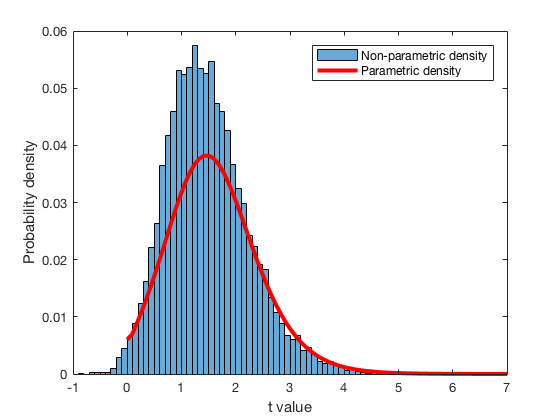

In [7]:
% Use a parametric test to estimate smoothness:
spm  = spm1d.stats.ttest2(Pin_Force_Bow_Male', Pin_Force_Bow_Female');
fwhm = spm.fwhm;   %smoothness

% Assemble other parameters:
df   = 18;  %degrees of freedom
Q    = 51;  %continuum length (in nodes)


% Construct the (parametric) RFT density:
x  = linspace(0, 7, 80);
sf = zeros(80,1);  %survival function
for i = 1:80
    sf(i) = spm1d.rft1d.t.sf(x(i), df, Q, fwhm);
end
pdf = gradient(1 - sf);  %probability density


% Plot results
histogram( snpmi.PDF0, 'normalization', 'probability' )
hold on
plot(x, pdf, 'r-', 'linewidth', 3)
xlabel('t value')
ylabel('Probability density')
legend('Non-parametric density', 'Parametric density')


From these results we can see the the non-parametric density closely follows the parametric density for high t values (t>2). RFT probabilities are valid only for high t values, so the parametric density follows the non-parametric density only for t > 2, but this is not a problem because we are only interested in the upper end of this distribution, and in particular in identifying the the 95th percentile, which is well above t=2.

Last, note that RFT uses just two parametrs:  the degrees of freedom (df) and the ratio: (Q-1)/fwhm, which is the resel count for this dataset (see notebook #2). Based on those two values RFT computes probabilities analytically, and effectively instantaneously.  The permutation approach takes order-of-magnitude longer duration to estimate the same probabilities non-parametrically.



